In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import time
import pandas as pd


## Processing Data

#### Display the first 25 images from the dataset and their labels to get a sense of what the images looks like. We selected five writers and label them from 0000 to 0004 as shown in the images. Just by human eyes, it is really hard to tell the difference between different writers. 

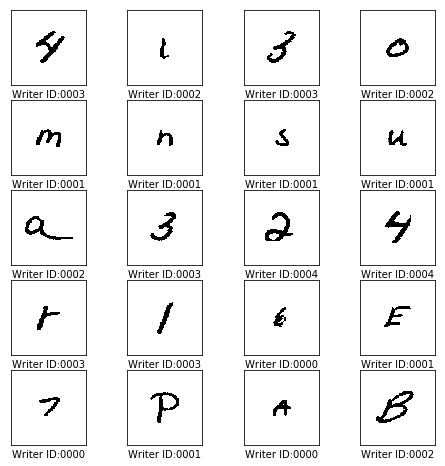

<Figure size 432x288 with 0 Axes>

In [2]:
columns = 4
rows = 5
fig=plt.figure(figsize=(8, 8))
index = 1
for image in os.listdir('output'):
    if not image.endswith('e'):
        label = (image[:4])
        image_path = 'output/' + image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(rows, columns, index)
        plt.xlabel("Writer ID:" + label)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap="gray")
        index +=1
        if index==21:
            break
plt.show()
plt.savefig('img/show25.png', bbox_inches='tight')

#### Test different sizes for the model. The original format is 128 * 128. Although larger sizes will retain more features of the image, the running speed will decreased. Through the comparison, I think 64 * 64 is suitable for modelling. I can still recognize the shape of the letter and the running speed decreased dramatically. 

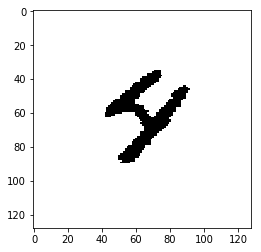

In [3]:
for image in os.listdir('output'):
    label = image[:4]
    image_path = 'output/' + image
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break

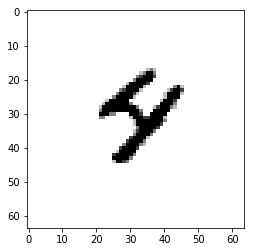

In [4]:
# test the suitable image size to use, 64 seems reasonable
SIZE = 64
new_array = cv2.resize(img_array, (SIZE, SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

#### Read the image into a training dataset. All images are already been processed in [Image Handler](https://github.com/albertli354/Final-Project-Info370/blob/tensorflow/handle_image.ipynb). The images' file name indicates the writer's ID. 

#### For the dataset, I created a feature called 'image', which contains a 2D array represents the grayscale of each pixel in the image. I also created a feature called 'writer_ID', which indicates the owner of the image.

In [5]:
training_data = []

def create_training_data():
    for image in os.listdir('output'):
        if not image.endswith('e'):
            label = int(image[:4])
            image_path = 'output/' + image
            img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (SIZE, SIZE)) # resize
            training_data.append([new_array, label])
create_training_data()

Check the train date for my model. Make sure the images are distribute randomly. 

In [6]:
# check dataset, all labels are random
for sample in training_data[:10]:
    print(sample[1])

3
2
3
2
1
1
1
1
2
3


In [7]:
X = []
y = []

In [8]:
for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, SIZE, SIZE, 1) 
X= X/255.0 # normalize data

## Building Model

For this model, I used a **Convolutional Neural Network** (CNN) to predict the author. I tested different layer sizes, convolutional layers sizes, and dense layer sizes for better prediction. I also test the accuracy for different image size and number of writers. 

For my final model, I used a one hidden layer with size of 32 neurons. For the convolutional layer, I also use a size of 32. After some comparion, I decided to use a 64 * 64 size. In this size, the image can still be clearly recognized and the running speed improved a lot compared with 128 * 128. I used a `sparse_categorical_crossentropy` as the loss function since writers' IDs are categorical labels and we have more than two kinds of labels in the dataset.

For the model, I use 10% of the data as validation test and a batch size of 12 to run the test. I decided to use a 15 epochs for the model since the validation accuracy shows a decrease in the 14th epoch. 

In [2]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [10]:
NAME = "5-Writer-cnn{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [11]:
model = Sequential()
model.add( Conv2D(32, (3,3), input_shape=X.shape[1:]) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

            
# model.add(Flatten())
model.add( Conv2D(32, (3,3), input_shape=X.shape[1:]) )
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
            
model.add(Flatten())
model.add(Dense(5, activation=tf.nn.softmax))

In [12]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.fit(X, y, validation_split=0.1, 
          epochs=15, 
          batch_size=12, 
          callbacks=[tensorboard])

Train on 1719 samples, validate on 192 samples
Epoch 1/15
1719/1719 [==============================] - 5s 3ms/sample - loss: 1.4562 - accuracy: 0.3455 - val_loss: 1.2398 - val_accuracy: 0.4948
Epoch 2/15
1719/1719 [==============================] - 4s 3ms/sample - loss: 1.1813 - accuracy: 0.5224 - val_loss: 1.0285 - val_accuracy: 0.6042
Epoch 3/15
1719/1719 [==============================] - 4s 3ms/sample - loss: 0.9356 - accuracy: 0.6300 - val_loss: 0.8211 - val_accuracy: 0.7135
Epoch 4/15
1719/1719 [==============================] - 4s 3ms/sample - loss: 0.7764 - accuracy: 0.7010 - val_loss: 0.8071 - val_accuracy: 0.6979
Epoch 5/15
1719/1719 [==============================] - 4s 3ms/sample - loss: 0.6869 - accuracy: 0.7417 - val_loss: 0.7620 - val_accuracy: 0.7344
Epoch 6/15
1719/1719 [==============================] - 4s 3ms/sample - loss: 0.6057 - accuracy: 0.7650 - val_loss: 0.7251 - val_accuracy: 0.7135
Epoch 7/15
1719/1719 [==============================] - 4s 3ms/sample - loss:

## Reflection on the Model Result

Through a series of modelling, we can see that the accuracy is not always improved as the number of epoches increased. Sometimes the accuracy even decreased with more training. 

In [1]:
%load_ext tensorboard.notebook
%tensorboard --logdir logs/
%reload_ext tensorboard.notebook

Reusing TensorBoard on port 6008 (pid 83235), started -1 day, 23:02:01 ago. (Use '!kill 83235' to kill it.)

![title](img/accuracy.png)

From the image above, we can see how **validation accuracy** changed with the number of epoches and number of writers in the dataset. From the data, as the number of writers in the dataset increased, the accuracy score decreased proportionally. 

For a five-writers datset, the  validation accuracy could reach at 76% and the train accuracy can even at 90%. However, when the number of writers increased to 30, validation accuracy only decreased to 43% and train accuracy decreased to 81%. As the number of writers increased in the dataset, it is really hard for the model to calculate all the subtle differences. 

Another intersting point is the relationship between the number of epoches and accuracy.Both of the four models experienced a dramatically increase in accuracy from the beginning to the second round. However, for the validation accuracy, the accuracy score seems not changed much, and even experience small decreases when the number of epoches increased (see the image below). For instance, for 10 and 20 writer model, the accracy score decreased in the last epoch.


![title](img/validation.png)